handle text features 

- tfidf + tsvd 
- binarize tfidf + tsvd 
- hashing + tsvd 
- binarize + tsvd 

some notes : 
- constraint on ngram=(1,2), max_features = 10^5
- tsvd to dim =5 

In [1]:
import pandas as pd 
import numpy as np 


In [2]:
%%time
df_train = pd.read_pickle('../input/train.pkl')
df_test = pd.read_pickle('../input/test.pkl')

Wall time: 6.78 s


In [3]:
df_train.columns

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'activation_date',
       'user_type', 'image', 'image_top_1', 'deal_probability'],
      dtype='object')

In [4]:
title_text_raw = df_train.title.append(df_test.title)
title_text_raw.reset_index(drop=True,inplace=True)

In [5]:
title_text_raw.shape

(2011862,)

##### tfidf + tsvd

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [9]:
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [41]:
## tfidf 
tv = TfidfVectorizer(lowercase=False,ngram_range=(1,2),max_features=100000)
tv_feats = tv.fit_transform(title_text_raw)
print('shape of tfidf Vectorizer:{}'.format(tv_feats.shape))

shape of tfidf Vectorizer:(2011862, 100000)


In [68]:
svd = TruncatedSVD(n_components=5, random_state=0)
tv_svd_feats = svd.fit_transform(tv_feats)
print('shape of tv_svd_feats:',tv_svd_feats.shape)

shape of tv_svd_feats: (2011862, 5)


In [69]:
# print(svd.explained_variance_ratio_)
print(np.cumsum(svd.explained_variance_ratio_)) ## 4% variance ratio only

[ 0.01133474  0.02288095  0.02933777  0.03516342  0.04054833]


In [70]:
tv_svd_df = pd.DataFrame(tv_svd_feats).iloc[:df_train.shape[0]]
tv_svd_df['y'] = df_train.deal_probability

tv_svd_df.corr()['y']

0    0.012604
1   -0.058977
2   -0.029999
3   -0.039952
4   -0.038997
y    1.000000
Name: y, dtype: float64

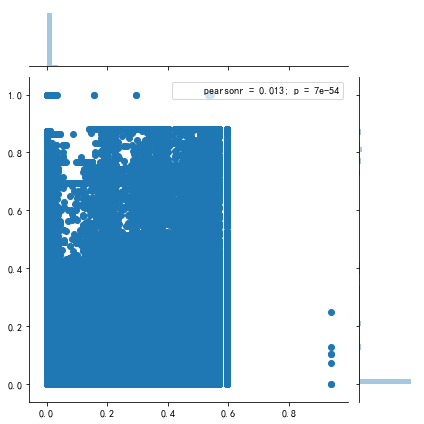

In [72]:
sns.jointplot(x = tv_svd_df[0].values, y=tv_svd_df['y'].values)

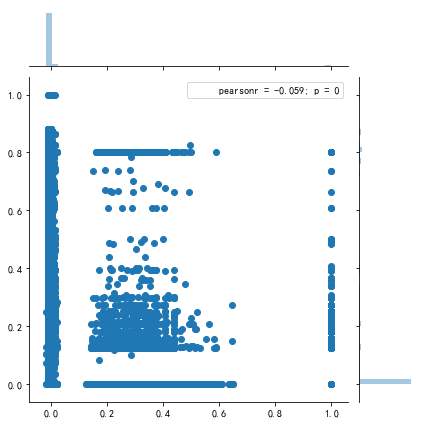

In [71]:
sns.jointplot(x = tv_svd_df[1].values, y=tv_svd_df['y'].values)

##### hashing + tsvd (title)

In [81]:
from sklearn.feature_extraction.text import HashingVectorizer

hv = HashingVectorizer(ngram_range=(1, 2), lowercase=False)
hv_features = hv.fit_transform(title_text_raw).tocsr()
print('shape of hv features:{}'.format(hv_features.shape))

svd = TruncatedSVD(n_components=5, random_state=0)
hv_svd_features = svd.fit_transform(hv_features)


shape of hv features:(2011862, 1048576)


In [85]:
np.cumsum(svd.explained_variance_ratio_) # 6.8%

array([ 0.02536404,  0.03807298,  0.04976278,  0.0591476 ,  0.06888894])

In [88]:
hv_svd_df = pd.DataFrame(hv_svd_features).iloc[:df_train.shape[0]]
hv_svd_df['y'] = df_train.deal_probability


In [91]:
hv_svd_df.corr().y

0    0.010472
1   -0.071248
2   -0.023938
3   -0.017528
4    0.039344
y    1.000000
Name: y, dtype: float64

______
do the same thing in description

In [109]:
desc_raw = df_train.description.append(df_test.description)
desc_raw.fillna('',inplace=True)
desc_raw.reset_index(drop=True,inplace=True)

In [112]:
## tfidf  + svd 
tv = TfidfVectorizer(lowercase=False,ngram_range=(1,2),max_features=100000)
tv_feats = tv.fit_transform(desc_raw)

print('shape of tfidf Vectorizer:{}'.format(tv_feats.shape))

svd = TruncatedSVD(n_components=5, random_state=0)
tv_svd_feats1 = svd.fit_transform(tv_feats)
print('shape of tv_svd_feats:',tv_svd_feats.shape)

shape of tfidf Vectorizer:(2011862, 100000)
shape of tv_svd_feats: (2011862, 5)


In [113]:
svd.explained_variance_ratio_

array([ 0.00768117,  0.00573284,  0.00265744,  0.00309605,  0.00270865])

In [117]:
## hashing + svd 

hv = HashingVectorizer(ngram_range=(1, 2), lowercase=False)
hv_features = hv.fit_transform(desc_raw).tocsr()
print('shape of hv features:{}'.format(hv_features.shape))

svd = TruncatedSVD(n_components=5, random_state=0)
hv_svd_features1 = svd.fit_transform(hv_features)


shape of hv features:(2011862, 1048576)


In [122]:
hv_svd_features1.shape
tv_svd_feats1.shape

(2011862, 5)

### save hdf5

In [128]:
all_text_feats =  np.concatenate([tv_svd_feats,hv_svd_features,tv_svd_feats1,hv_svd_features1],axis=1)

In [131]:
df_text_feats = pd.DataFrame(all_text_feats)
colnames = ['title_tfidf_{}'.format(e) for e in range(5)] + ['title_hash_{}'.format(i) for i in range(5)] + \
            ['desc_tfidf_{}'.format(e) for e in range(5)] + ['desc_hash_{}'.format(i) for i in range(5)] 
df_text_feats.columns = colnames

In [133]:
df_text_feats.head().T

,0,1,2,3,4
title_tfidf_0,0.000135,0.000157,0.000061,0.000030,0.000003
title_tfidf_1,0.002495,0.002864,0.000004,0.000008,-0.000003
title_tfidf_2,0.002115,0.002427,0.000159,0.000039,-0.000105
title_tfidf_3,0.006663,0.007652,0.000013,0.000018,0.000266
title_tfidf_4,0.007393,0.008495,0.000040,0.000020,-0.000409
title_hash_0,0.000401,0.000474,0.000010,0.000012,0.000002
title_hash_1,0.038004,0.044983,0.000046,0.000034,0.000006
title_hash_2,0.023695,0.028033,0.000127,0.000051,0.000022
title_hash_3,0.255297,0.302206,0.000369,0.000231,-0.000041
title_hash_4,-0.237912,-0.281707,-0.000005,-0.000100,-0.000028


In [143]:
df_text_feats.iloc[:100,1].dtype =='float64'

True

In [144]:
def downcast(df):
    for idx, col in enumerate(df):
        if df.iloc[:,idx].dtypes == 'float64':
            df[col] = df[col].astype('float32')
        else:
            pass    

In [145]:
downcast(df_text_feats)

In [151]:
df_text_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011862 entries, 0 to 2011861
Data columns (total 20 columns):
title_tfidf_0    float32
title_tfidf_1    float32
title_tfidf_2    float32
title_tfidf_3    float32
title_tfidf_4    float32
title_hash_0     float32
title_hash_1     float32
title_hash_2     float32
title_hash_3     float32
title_hash_4     float32
desc_tfidf_0     float32
desc_tfidf_1     float32
desc_tfidf_2     float32
desc_tfidf_3     float32
desc_tfidf_4     float32
desc_hash_0      float32
desc_hash_1      float32
desc_hash_2      float32
desc_hash_3      float32
desc_hash_4      float32
dtypes: float32(20)
memory usage: 153.5 MB


In [152]:
df_text_feats.shape

(2011862, 20)

In [154]:
len_trn = df_train.shape[0]

In [155]:
store = pd.HDFStore('../input/feats/txt_td_tfidf_hash5.h5')
store['df_trn_text_feat'] = df_text_feats.iloc[:len_trn,:]
store['df_test_text_feat'] = df_text_feats.iloc[len_trn:,:]
store.close()